In [2]:
%uv pip install numerapi pyarrow numerai-tools xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import warnings

import pandas as pd
import numpy as np

from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr

from sklearn.linear_model import Ridge 
import xgboost as xgb

np.random.seed(42)


# Introduction

Lets start by loading the train and validation dataset

In [4]:
DATA_VERSION = "v5.1"
napi = NumerAPI()

napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]
feature_set = feature_sets["all"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set
)

# Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "target"] + feature_set
)

validation = validation.dropna()


#Keep the last 100th eras for test set
validation_era = validation["era"].unique()[:-100]
validation = validation[validation["era"].isin(validation_era)]

2025-12-17 14:31:26,755 INFO numerapi.utils: starting download
v5.1/features.json: 307kB [00:00, 1.34MB/s]                                                                    
2025-12-17 14:31:27,850 INFO numerapi.utils: starting download
v5.1/train.parquet: 2.47GB [01:34, 26.2MB/s]                                                                   
2025-12-17 14:33:10,952 INFO numerapi.utils: starting download
v5.1/validation.parquet: 3.82GB [02:23, 26.6MB/s]                                                              


We remove first validation eras to prevent data leakage.

In [5]:

# Eras are 1 week apart, but targets look 20 days (o 4 weeks/eras) into the future,
# so we need to "embargo" the first 4 eras following our last train era to avoid "data leakage"
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]

validation = validation[~validation["era"].isin(eras_to_embargo)]

### Motivation

The goal of this notebook is to run some experiments with different features selection.

We then check for some metrics on validation dataset which will allow us to decide which set of features to keep.

### Performance evaluation

Numerai calculates scores designed to "align incentives" between your model and the hedge fund - a model with good scores should help the hedge fund make good returns. The primary scoring metrics in Numerai are:

- `CORR` (or "Correlation") which is calculated by the function [numerai_corr](https://docs.numer.ai/numerai-tournament/scoring/correlation-corr) - a Numerai specific variant of the Pearson Correlation between your model and the target.

- `MMC` (or "Meta Model Contribution") which is a calculated by the function `correlation_contribution` - a measure of how uniquely additive your model is to the Numerai Meta Model.

Our goal in this project is to maximize `CORR` to have the "best" strategy.


To assess the quality of a prediction, we will use the following metrics:

-  `mean`: Average correlation over the eras: Indicator of the raw performance of the model

- `std`: Standard deviation over the eras: Indicator of the stability of a model.

- `corr_sharpe`: Sharp ratio of the correlation: Indicator of how risky the model is.

- `corr_max_drawdown`: Max drowdown of the model: Indicator of how much we may lose.

- `hit_rate`: Success rate indicator.

- `max_feature_exposure_mean`

- `max_feature_exposure_std`



In [6]:


def fit_and_evaluate_model(model, train, validation, feature_set):
    """
    Fit a model and evaluate it on validation data.
    
    Parameters:
    -----------
    model : sklearn/xgboost model
        Model to fit and evaluate
    train : pandas.DataFrame
        Training data with features and target
    validation : pandas.DataFrame
        Validation data with features and target
    feature_set : list
        List of feature names to use for training and prediction
    
    Returns:
    --------
    per_era_corr : pandas.Series
        Per-era correlation scores
    """
    # Fit model and make predictions
    model.fit(train[feature_set], train["target"])

    # Batch prediction to avoid memory issues
    batch_size = 10000  # Adjust based on your memory constraints
    predictions = []
    
    for i in range(0, len(validation), batch_size):
        batch = validation.iloc[i:i+batch_size]
        batch_predictions = model.predict(batch[feature_set])
        predictions.append(batch_predictions)
    
    validation["prediction"] = np.concatenate(predictions)
    

    # Compute per-era correlation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        per_era_corr = validation.groupby("era").apply(
            lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna()),
            include_groups=False
        )
        per_era_corr.fillna(0, inplace=True)

    # Compute performance metrics
    corr_mean = per_era_corr.mean().item()
    corr_std = per_era_corr.std(ddof=0).item()
    corr_sharpe = corr_mean / corr_std if corr_std > 0 else np.nan
    corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max().item()
    corr_hit_rate = (per_era_corr > 0).mean().item()


    # Display performance metrics
    print("=" * 60)
    print("MODEL PERFORMANCE METRICS")
    print("=" * 60)
    print(f"Mean:           {corr_mean:>10.6f}")
    print(f"Std:            {corr_std:>10.6f}")
    print(f"Sharpe:         {corr_sharpe:>10.4f}")
    print(f"Max Drawdown:   {corr_max_drawdown:>10.6f}")
    print(f"Hit Rate:       {corr_hit_rate:>10.2%}")
    print()

    # Compute feature exposures
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        feature_exposures = validation.groupby("era").apply(
            lambda d: d.drop(columns=["target", "prediction"]).corrwith(d["prediction"]),
            include_groups=False
        )
        feature_exposures.fillna(0, inplace=True)

    # Display feature exposure metrics
    max_feature_exposure = feature_exposures.max(axis=1)
    print("FEATURE EXPOSURE")
    print("=" * 60)
    print(f"Max Feature Exposure - Mean: {max_feature_exposure.mean():.4f}")
    print(f"Max Feature Exposure - Std:  {max_feature_exposure.std():.4f}")
    print("=" * 60)
    print()

    return per_era_corr

# Baseline

We use a linear regression as baseline. Its performances are quite mediocre.

MODEL PERFORMANCE METRICS
Mean:             0.021993
Std:              0.017937
Sharpe:             1.2261
Max Drawdown:     0.118468
Hit Rate:           89.32%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.1756
Max Feature Exposure - Std:  0.0280



2025-12-17 13:06:59,696 INFO matplotlib.font_manager: generated new fontManager


<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

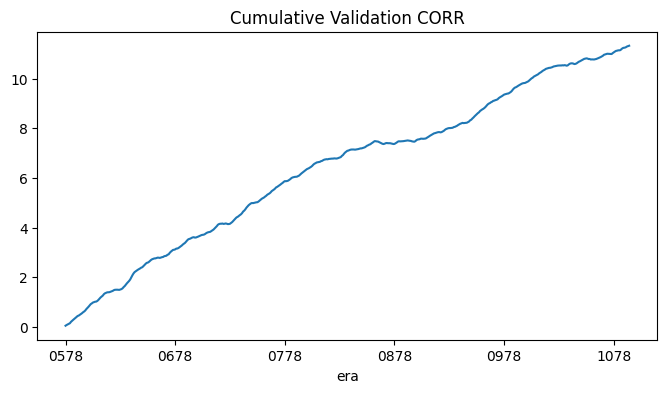

In [6]:
model = Ridge(alpha=10, random_state=42)

per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

# XGBoost

We then use XGBoost which is a very good model for large features dataset with binned data.

It allow to draw any boundary decision.

## Feature Set All

We first try to fit that model on the whole dataset.

MODEL PERFORMANCE METRICS
Mean:             0.034296
Std:              0.022220
Sharpe:             1.5435
Max Drawdown:     0.089351
Hit Rate:           92.83%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2390
Max Feature Exposure - Std:  0.0408



<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

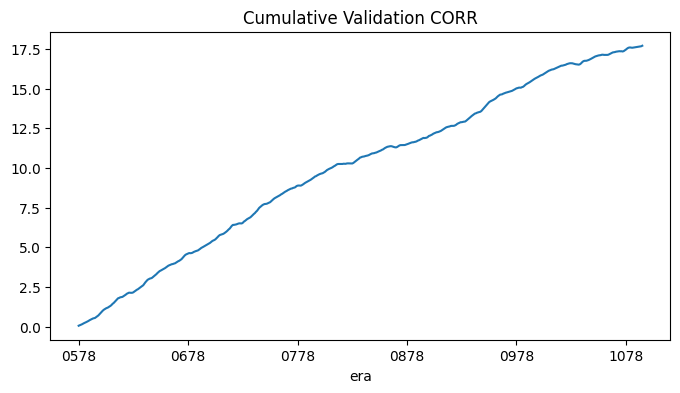

In [10]:
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    colsample_bytree=0.1,
    verbosity=0,
    seed=42,
    tree_method="hist",
    device="cuda",
)

per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

### Feature selection via previous feature importance

One regularization method we try is to actually select the features with the most important decision power according the previous trained model.

In [8]:
importance = model.feature_importances_
sorted_idx = np.argsort(importance)[::-1]

for n in [100, 200, 500, 1000]:
  top_features = [feature_set[i] for i in sorted_idx[:n]]
  model = xgb.XGBRegressor(
      n_estimators=2000,
      learning_rate=0.01,
      max_depth=5,
      colsample_bytree=0.1,
      verbosity=0,
      seed=42,
      tree_method="hist",
      device="cuda",
  )

  per_era_corr = fit_and_evaluate_model(model, train, validation, top_features)


MODEL PERFORMANCE METRICS
Mean:             0.023590
Std:              0.021088
Sharpe:             1.1187
Max Drawdown:     0.189489
Hit Rate:           89.13%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2525
Max Feature Exposure - Std:  0.0231

MODEL PERFORMANCE METRICS
Mean:             0.028212
Std:              0.021246
Sharpe:             1.3279
Max Drawdown:     0.110680
Hit Rate:           91.46%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2440
Max Feature Exposure - Std:  0.0321

MODEL PERFORMANCE METRICS
Mean:             0.033352
Std:              0.022759
Sharpe:             1.4654
Max Drawdown:     0.082334
Hit Rate:           92.04%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2348
Max Feature Exposure - Std:  0.0357

MODEL PERFORMANCE METRICS
Mean:             0.034296
Std:              0.022452
Sharpe:             1.5275
Max Drawdown:     0.087510
Hit Rate:           94.17%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2329
Max Feature Exposure - Std:  

### Feature selection via correlation sharp ratio

One regularization method we try is by selecting only the 1000 features with the highest correlation sharp ratio

In [7]:
n_splits = 15
n_features = 1000

# Split dataset into n_splits parts
n_samples = len(train)
samples_per_split = n_samples // n_splits

# Store correlations for each split
split_corrs = []

for i in range(n_splits):
    start_idx = i * samples_per_split
    end_idx = (i + 1) * samples_per_split if i < n_splits - 1 else n_samples
    
    split_data = train.iloc[start_idx:end_idx]
    
    # Compute correlation for this split
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        corr = split_data.drop(columns=["era", "target"]).corrwith(
            split_data['target'], method='pearson'
        )
    
    # Set NaN (from zero variance) to 0
    corr = corr.fillna(0)
    
    split_corrs.append(corr)

# Convert to DataFrame (rows = splits, columns = features)
split_corr_df = pd.DataFrame(split_corrs)

# Compute statistics across splits
feature_mean_corr_split = split_corr_df.mean(axis=0).abs()  # Mean correlation per feature
feature_std_corr_split = split_corr_df.std(axis=0)  # Std across splits
feature_sharp_corr_split = feature_mean_corr_split / feature_std_corr_split  # Sharpe ratio

feature_set_sharp = feature_sharp_corr_split.sort_values(ascending=False).index[:n_features]


MODEL PERFORMANCE METRICS
Mean:             0.030724
Std:              0.021761
Sharpe:             1.4119
Max Drawdown:     0.083185
Hit Rate:           91.09%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2490
Max Feature Exposure - Std:  0.0383



2025-12-17 14:47:06,323 INFO matplotlib.font_manager: generated new fontManager


<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

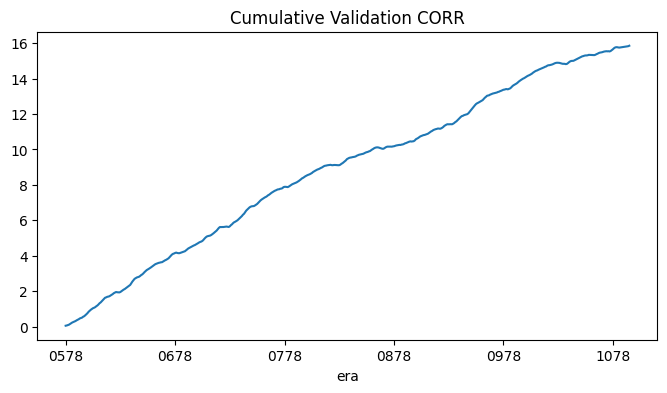

In [8]:
model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    colsample_bytree=0.1,
    verbosity=0,
    seed=42,
    tree_method="hist",
    device="cuda",
)
  
per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set_sharp)


# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

## Feature Set Medium

Now we try to fit the model only on the features from the medium dataset

MODEL PERFORMANCE METRICS
Mean:             0.032647
Std:              0.021442
Sharpe:             1.5225
Max Drawdown:     0.072203
Hit Rate:           95.16%

FEATURE EXPOSURE
Max Feature Exposure - Mean: 0.2216
Max Feature Exposure - Std:  0.0398



<Axes: title={'center': 'Cumulative Validation CORR'}, xlabel='era'>

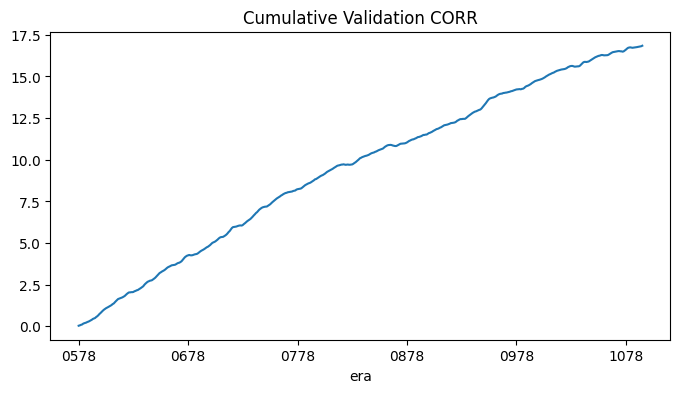

In [9]:
feature_set_medium = feature_sets["medium"]

model = xgb.XGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    colsample_bytree=0.1,
    verbosity=0,
    seed=42,
    tree_method="hist",
    device="cuda",
)
  
per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set_medium)


# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)

From the results we observe than non of the features selection techniques used actually improve the performances. 

The final method we are gonna use is XGBoost on `all` feature set.

# Hyperparameters Tuning

As suggested by numerai, we are gonna try to increase the numbers of trees and their depth as well as reduce the learning rate.

This is expected to significantly improve our performances given the dataset size.

In [ ]:
model = xgb.XGBRegressor(
    n_estimators=30000,
    learning_rate=0.001,
    max_depth=10,
    colsample_bytree=0.1,
    verbosity=0,
    seed=42,
    tree_method="hist",
    device="cuda",
)

per_era_corr = fit_and_evaluate_model(model, train, validation, feature_set)

# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
title="Cumulative Validation CORR",
kind="line",
figsize=(8, 4),
legend=False
)